In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    f1_score,
    precision_score,
    recall_score,
    confusion_matrix,
)
from sklearn.calibration import calibration_curve

# Fixing all random seeds
SEED = 2025
np.random.seed(SEED)
random.seed(SEED)


nb_classes = 2
labels = ["Pas de Récidive", "Récidive"]
ticksx = np.arange(nb_classes) + 0.5
ticksy = np.arange(nb_classes) + 0.5

## utils 

In [2]:
def compute_metrics(y_test, y_pred):
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")  # Use "weighted" for multiclass
    PPV = precision_score(y_test, y_pred, average="weighted")
    Sensitivity = recall_score(y_test, y_pred, average="weighted")
    return accuracy, balanced_accuracy, f1, PPV, Sensitivity


def getWrongPatients(yhat, ytrue, patients):
    if len(np.where(yhat != ytrue)) != 0:
        return patients[np.where(yhat != ytrue)]
    else:
        print("No Misclassified Patients.")
        return np.array([0])

## codes

In [3]:
patients_KB_to_eliminate = [23, 31, 54, 60, 68, 72, 76, 84, 86]
patients_R1_to_eliminate = [116, 117, 125, 134, 156, 180, 197, 198]
patients_NaN_to_eliminate = [
    18,
    70,
    114,
    116,
    119,
    212,
]  # 113, 124, 129, 138, 139, 143, 145, 155, 159]

patients_to_eliminate = [208, 231, 250] + list(
    set(patients_KB_to_eliminate + patients_R1_to_eliminate + patients_NaN_to_eliminate)
)
print(len(patients_to_eliminate), sorted(patients_to_eliminate))

df = pd.read_excel("../data/tabs/input_dataframe_prognosis.xlsx")
df = (
    df.loc[~df["patient"].isin(patients_to_eliminate)]
    .sort_values(by="patient")
    .drop("Nbre de lames", axis=1)
)

25 [18, 23, 31, 54, 60, 68, 70, 72, 76, 84, 86, 114, 116, 117, 119, 125, 134, 156, 180, 197, 198, 208, 212, 231, 250]


In [4]:
df_kb = df.loc[
    df["patient"].between(1, 110)
    | df["patient"].between(213, 222)
    | df["patient"].between(253, 260)
]
df_hm = df.loc[df["patient"].between(111, 160)]
df_bj = df.loc[df["patient"].between(161, 212) | df["patient"].between(223, 252)]

df_kb.shape, df_hm.shape, df_bj.shape

((111, 20), (43, 20), (67, 20))

In [5]:
df_kb["Récidive Globale"].value_counts()

Récidive Globale
1    57
0    54
Name: count, dtype: int64

In [6]:
df_hm["Récidive Globale"].value_counts()

Récidive Globale
1    23
0    20
Name: count, dtype: int64

In [7]:
df_bj["Récidive Globale"].value_counts()

Récidive Globale
0    41
1    26
Name: count, dtype: int64

In [8]:
cols_to_scale = [
    "Pattern expansif multinodulaire",
    "log1p_taille",
    "log1p_AFP",
    "%P",
    "%P_max",
    "NP_CntArea_norm",
    "P_CntArea_norm",
    "P_CntArea_norm_max",
    "Intra-tumoral",
    "Peri-tumoral",
    "density",
    "mean nucleus area",
    "anisocaryose",
    "nucleocyto index",
]

In [9]:
train = df_kb.loc[df_kb["patient"].between(1, 89)]
test = df_kb.loc[~df_kb["patient"].between(1, 89)]

robust_scaler = RobustScaler()
data_scaled = robust_scaler.fit_transform(train[cols_to_scale])
# Kremlin Bicetre
train[cols_to_scale] = data_scaled
data_scaled = robust_scaler.transform(test[cols_to_scale])
test[cols_to_scale] = data_scaled

# HenriMondor
data_scaled = robust_scaler.transform(df_hm[cols_to_scale])
df_hm[cols_to_scale] = data_scaled

# Beaujon
data_scaled = robust_scaler.transform(df_bj[cols_to_scale])
df_bj[cols_to_scale] = data_scaled

FINAL_COLS = cols_to_scale
X_train = train[FINAL_COLS]
y_train = train["Récidive Globale"]

X_test = test[FINAL_COLS]
y_test = test["Récidive Globale"]
patients_train = train["patient"]
patients_test = test["patient"]

X_hm = df_hm[FINAL_COLS]
y_hm = df_hm["Récidive Globale"]
patients_hm = df_hm["patient"]

X_bj = df_bj[FINAL_COLS]
y_bj = df_bj["Récidive Globale"]
patients_bj = df_bj["patient"]

In [10]:
models = {
    "SVM (kernel=rbf)": SVC(
        kernel="rbf", random_state=SEED, probability=True, C=1.5, gamma="scale"
    ),
}

In [11]:
results = pd.DataFrame(
    columns=[
        "Model",
        "Accuracy",
        "Balanced Accuracy",
        "F1-Score",
        "PPV",
        "Sensitivity",
    ]
)
results_hm = pd.DataFrame(columns=results.columns)
results_bj = pd.DataFrame(columns=results.columns)
results["Model"] = list(models.keys())
results_hm["Model"] = list(models.keys())
results_bj["Model"] = list(models.keys())

cm_results_hm = {}
cm_results_bj = {}
cm_results = {}
dict_models = {}
for name, model in models.items():
    print(f"Training {name}...", end="")
    model.fit(X_train, y_train)  # Train the model

    y_pred = model.predict(X_test)  # Predict on KB
    accuracy, balanced_accuracy, f1, PPV, Sensitivity = compute_metrics(y_test, y_pred)
    model_results = pd.DataFrame(
        {
            "Model": [name],
            "Accuracy": [accuracy],
            "Balanced Accuracy": [balanced_accuracy],
            "F1-Score": [f1],
            "PPV": [PPV],
            "Sensitivity": [Sensitivity],
        }
    )
    model_results = model_results.dropna(axis=1, how="all")
    results.loc[results["Model"] == name] = [
        name,
        accuracy,
        balanced_accuracy,
        f1,
        PPV,
        Sensitivity,
    ]
    cm_results[name] = confusion_matrix(y_test, y_pred)

    y_pred_hm = model.predict(X_hm)  # Predict on HM
    accuracy, balanced_accuracy, f1, PPV, Sensitivity = compute_metrics(y_hm, y_pred_hm)
    results_hm.loc[results_hm["Model"] == name] = [
        name,
        accuracy,
        balanced_accuracy,
        f1,
        PPV,
        Sensitivity,
    ]
    cm_results_hm[name] = confusion_matrix(y_hm, y_pred_hm)

    y_pred_bj = model.predict(X_bj)  # Predict on BJ
    accuracy, balanced_accuracy, f1, PPV, Sensitivity = compute_metrics(y_bj, y_pred_bj)
    results_bj.loc[results_bj["Model"] == name] = [
        name,
        accuracy,
        balanced_accuracy,
        f1,
        PPV,
        Sensitivity,
    ]
    cm_results_bj[name] = confusion_matrix(y_bj, y_pred_bj)
    print(" Done!")

    y_proba = model.predict_proba(X_test)[:, 1]
    y_proba_hm = model.predict_proba(X_hm)[:, 1]
    y_proba_bj = model.predict_proba(X_bj)[:, 1]
    dict_models[name] = [
        model,
        y_pred,
        y_pred_hm,
        y_pred_bj,
        y_proba,
        y_proba_hm,
        y_proba_bj,
    ]

    y_proba = model.predict_proba(X_test)[:, 1]
    y_proba_hm = model.predict_proba(X_hm)[:, 1]
    y_proba_bj = model.predict_proba(X_bj)[:, 1]
    dict_models[name] = [
        model,
        y_pred,
        y_pred_hm,
        y_pred_bj,
        y_proba,
        y_proba_hm,
        y_proba_bj,
    ]

Training SVM (kernel=rbf)... Done!


In [12]:
results = results.sort_values(by="Accuracy", ascending=False)
results["hopital"] = "PB"

results_hm = results_hm.sort_values(by="Accuracy", ascending=False)
results_hm["hopital"] = "HM"

results_bj = results_bj.sort_values(by="Accuracy", ascending=False)
results_bj["hopital"] = "BJ"

ALL_res = pd.concat([results, results_hm])
ALL_res = pd.concat([ALL_res, results_bj])
ALL_res

,Model,Accuracy,Balanced Accuracy,F1-Score,PPV,Sensitivity,hopital
0,SVM (kernel=rbf),0.921053,0.919444,0.920888,0.922011,0.921053,PB
0,SVM (kernel=rbf),0.906977,0.903261,0.906467,0.909974,0.906977,HM
0,SVM (kernel=rbf),0.910448,0.905722,0.910448,0.910448,0.910448,BJ


In [13]:
print("misclassified patients:")
for m in results["Model"]:
    wrong_patients = getWrongPatients(
        dict_models[m][1], y_test.squeeze(), np.array(patients_test)
    )
    liste = list(set(wrong_patients))
    liste.sort()
    print("   {:10s} on PB:".format(m), liste)

for m in results_hm["Model"]:
    wrong_patients = getWrongPatients(
        dict_models[m][2], y_hm.squeeze(), np.array(patients_hm)
    )
    liste = list(set(wrong_patients))
    liste.sort()
    print("   {:10s} on HM:".format(m), liste)

for m in results_bj["Model"]:
    wrong_patients = getWrongPatients(
        dict_models[m][3], y_bj.squeeze(), np.array(patients_bj)
    )
    liste = list(set(wrong_patients))
    liste.sort()
    print("   {:10s} on BJ:".format(m), liste)

misclassified patients:
   SVM (kernel=rbf) on PB: [217, 222, 257]
   SVM (kernel=rbf) on HM: [113, 131, 132, 138]
   SVM (kernel=rbf) on BJ: [162, 168, 181, 185, 244, 248]


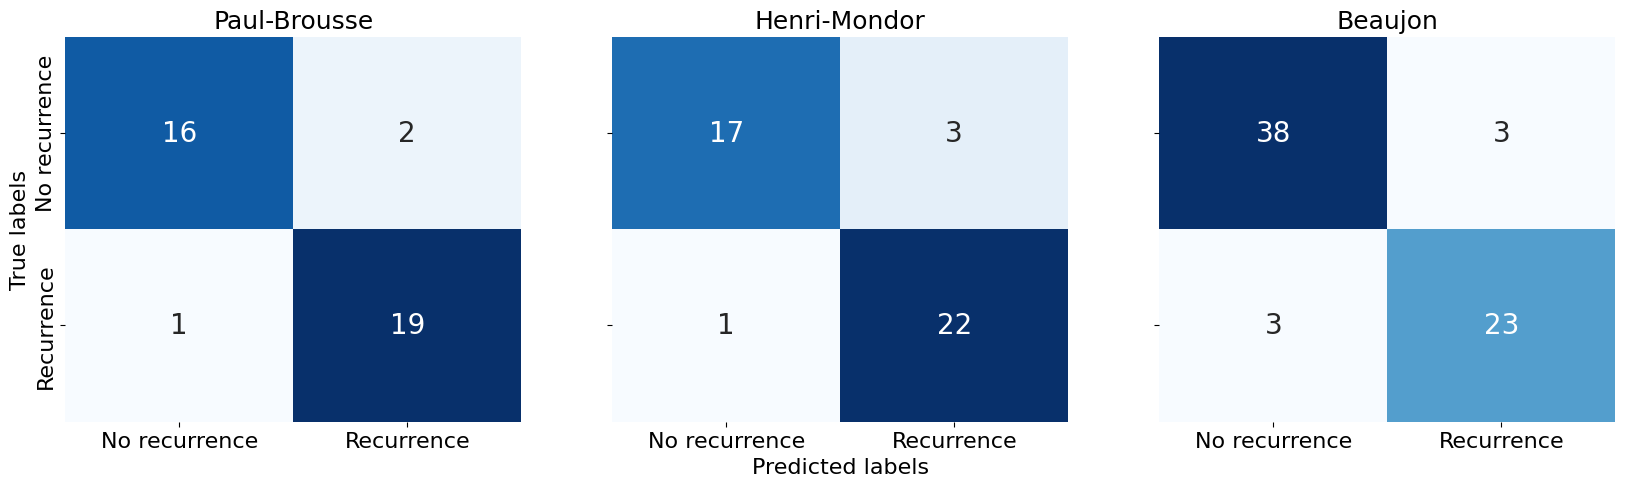

In [14]:
cm1 = cm_results["SVM (kernel=rbf)"]
cm2 = cm_results_hm["SVM (kernel=rbf)"]
cm3 = cm_results_bj["SVM (kernel=rbf)"]

cm_results = {"Paul-Brousse": cm1, "Henri-Mondor": cm2, "Beaujon": cm3}
labels = ["No recurrence", "Recurrence"]
rows, cols = 1, 3
fig, axes = plt.subplots(rows, cols, figsize=(20, 5), sharex=True, sharey=True)
axes = axes.flatten()
for idx, (model_name, cm) in enumerate(cm_results.items()):
    if idx >= rows * cols:
        break  # Stop if there are more models than grid cells

    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=axes[idx],
        cbar=False,
        xticklabels=labels,
        yticklabels=labels,
        annot_kws={"size": 20},
    )
    axes[idx].set_title(f"{model_name}", fontsize=18)
    axes[1].set_xlabel("Predicted labels", fontsize=16)
    axes[0].set_ylabel("True labels", fontsize=16)
    axes[idx].tick_params(axis="x", labelsize=16)
    axes[idx].tick_params(axis="y", labelsize=16)
for i in range(len(cm_results), rows * cols):
    fig.delaxes(axes[i])
plt.show()

## Calibration analysis

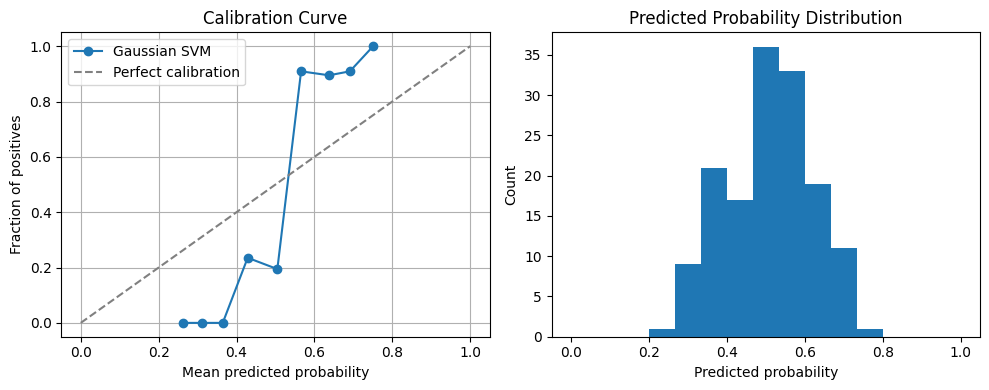

In [15]:
svm_model = models["SVM (kernel=rbf)"]
y_proba = svm_model.predict_proba(X_test)[:, 1]
y_pred = svm_model.predict(X_test)
y_proba_hm = svm_model.predict_proba(X_hm)[:, 1]
y_pred_hm = svm_model.predict(X_hm)
y_proba_bj = svm_model.predict_proba(X_bj)[:, 1]
y_pred_bj = svm_model.predict(X_bj)

PROBA = np.concatenate((y_proba, y_proba_hm, y_proba_bj), axis=None)
PREDS = np.concatenate((y_pred, y_pred_hm, y_pred_bj), axis=None)
TRUE = np.concatenate((y_test, y_hm, y_bj))

bins = 15
fraction_of_positives, mean_predicted_value = calibration_curve(
    TRUE, PROBA, n_bins=bins, strategy="uniform"
)

fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10, 4), sharex=True)
ax[0].plot(mean_predicted_value, fraction_of_positives, "o-", label="Gaussian SVM")
ax[0].plot([0, 1], [0, 1], "--", color="gray", label="Perfect calibration")
ax[0].set_xlabel("Mean predicted probability")
ax[0].set_ylabel("Fraction of positives")
ax[0].set_title("Calibration Curve")
ax[0].legend()
ax[0].grid(True)

ax[1].hist(PROBA, bins=bins, range=(0, 1))
ax[1].set_xlabel("Predicted probability")
ax[1].set_ylabel("Count")
ax[1].set_title("Predicted Probability Distribution")
plt.tight_layout()
plt.savefig(f"Calibration Curve PB+HM+BJ (bins={bins}).jpg")
plt.show()

## 5-folds cross validation

In [16]:
X = df_kb[["patient"] + FINAL_COLS]
y = df_kb[["patient", "Récidive Globale"]]
patients = df_kb["patient"].values

In [17]:
scores, f1s = [], []
cm_results = []
n_splits = 5
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=len(test))
for split_id, (train_idx, test_idx) in enumerate(
    sss.split(X, df_kb["Récidive Globale"].values), 1
):
    print("Split", split_id)
    model = SVC(kernel="rbf", C=1.5, gamma="scale")
    train_patients = sorted(patients[train_idx])
    test_patients = sorted(patients[test_idx])
    print(f"\ttrain_ptients:", len(train_patients), train_patients)
    print(f"\ttest_ptients:", len(test_patients), test_patients)

    X_train, X_test = (
        X.loc[X["patient"].isin(train_patients)],
        X.loc[X["patient"].isin(test_patients)],
    )
    y_train, y_test = (
        y.loc[y["patient"].isin(train_patients)]["Récidive Globale"].values,
        y.loc[y["patient"].isin(test_patients)]["Récidive Globale"].values,
    )

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    scores.append(acc)
    f1s.append(f1)
    cm_results.append(confusion_matrix(y_test, y_pred))
    print(f"\taccuracy = {acc:.3f}, f1-score = {f1:.3f}")

Split 1
	train_ptients: 73 [1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 16, 17, 19, 20, 21, 26, 28, 29, 30, 32, 34, 35, 36, 38, 40, 43, 46, 49, 51, 52, 55, 57, 62, 63, 64, 65, 66, 67, 69, 71, 73, 77, 79, 81, 83, 88, 89, 90, 91, 95, 98, 99, 100, 101, 102, 103, 104, 108, 109, 110, 213, 214, 215, 216, 217, 218, 222, 253, 254, 255, 258]
	test_ptients: 38 [6, 22, 24, 25, 27, 33, 37, 41, 42, 44, 45, 47, 48, 50, 53, 56, 58, 61, 75, 78, 80, 82, 85, 87, 92, 93, 94, 96, 97, 105, 106, 107, 219, 220, 221, 257, 259, 260]
	accuracy = 0.895, f1-score = 0.905
Split 2
	train_ptients: 73 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 16, 17, 20, 25, 26, 27, 28, 29, 30, 35, 37, 40, 43, 45, 46, 47, 48, 49, 51, 52, 53, 55, 56, 57, 69, 71, 73, 77, 78, 79, 80, 81, 82, 83, 85, 87, 88, 89, 91, 92, 95, 96, 97, 98, 102, 104, 106, 108, 109, 213, 214, 216, 218, 219, 221, 222, 254, 255, 257, 259, 260]
	test_ptients: 38 [12, 19, 21, 22, 24, 32, 33, 34, 36, 38, 41, 42, 44, 50, 58, 61, 62, 63, 64, 65, 66, 67, 75, 90, 93, 94, 99,

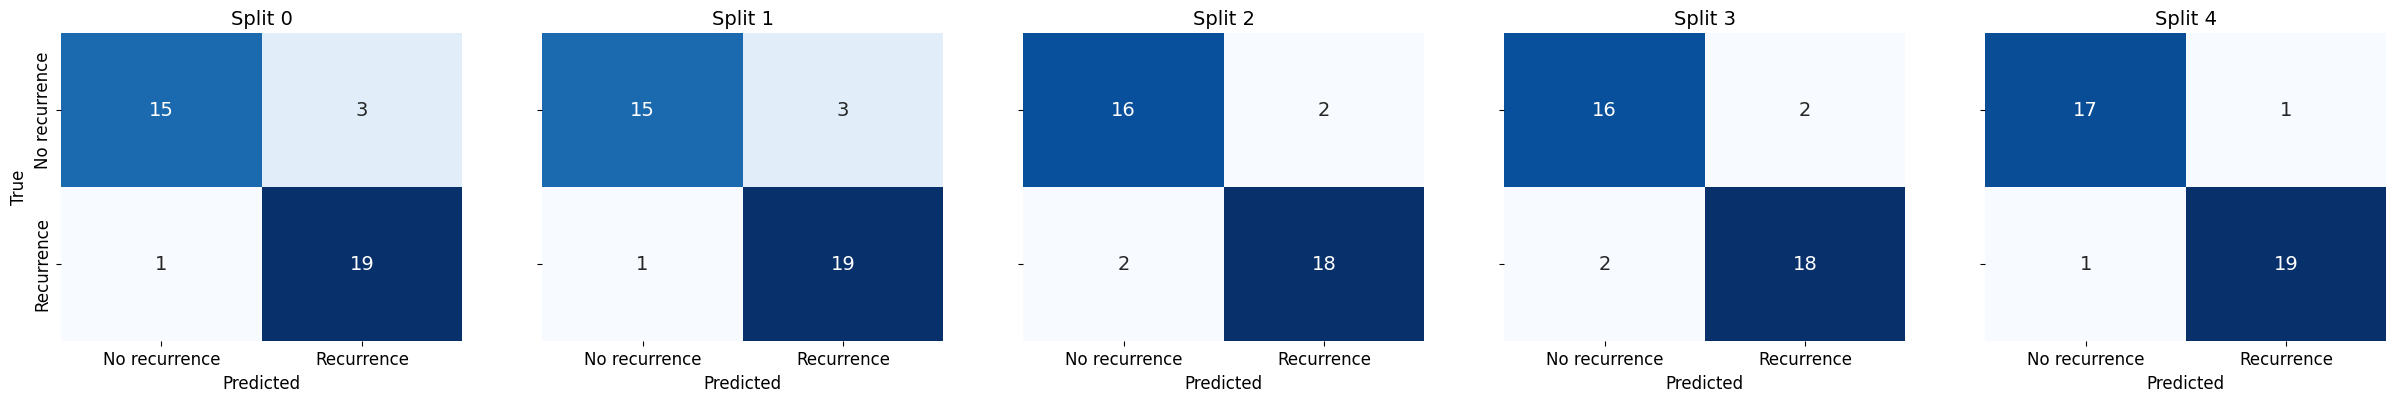

In [18]:
rows, cols = 1, n_splits
fig, axes = plt.subplots(rows, cols, figsize=(30, 4), sharex=True, sharey=True)
axes = axes.flatten()
for idx, cm in enumerate(cm_results):
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        ax=axes[idx],
        cbar=False,
        xticklabels=labels,
        yticklabels=labels,
        annot_kws={"size": 14},
    )
    axes[idx].set_title(f"Split {idx}", fontsize=14)
    axes[idx].set_xlabel("Predicted", fontsize=12)
    axes[0].set_ylabel("True", fontsize=12)
    axes[idx].tick_params(axis="x", labelsize=12)
    axes[idx].tick_params(axis="y", labelsize=12)
for i in range(len(cm_results), rows * cols):
    fig.delaxes(axes[i])
plt.savefig("cross val matrices.jpg")
plt.show()

In [19]:
print(f"Mean: acc={np.mean(scores):.3f}, f1-score={np.mean(f1s):.3f}")
print(f"Std: acc={np.std(scores):.3f}, f1-score={np.std(f1s):.3f}")

Mean: acc=0.905, f1-score=0.912
Std: acc=0.021, f1-score=0.019
